**Part 1 (20 points): This step involves downloading, preparing, and visualizing your
dataset. Create a convolutional base using a common pattern: a stack of Conv and
MaxPooling layers. Depending on the problem and the dataset you must decide what
pattern you want to use (i.e., how many Conv layers and how many pooling layers).
Please describe why you chose a particular pattern. Add the final dense layer(s).
Compile and train the model. Report the final evaluation and describe the metrics.**

dataset:https://www.kaggle.com/datasets/tongpython/cat-and-dog/data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_dir = "/content/drive/MyDrive/Ml_Al/hw5/training_set/training_set"
test_dir = "/content/drive/MyDrive/Ml_Al/hw5/test_set/test_set"

In [1]:
train_dir = "C:\\Users\\LiWeiJun\\Desktop\\project in MI and AI\\hw5\\training_set\\training_set"
test_dir = "C:\\Users\\LiWeiJun\\Desktop\\project in MI and AI\\hw5\\test_set\\test_set"

In [2]:
import os
import shutil
import random

#show the size of training_size and test_size

def count_images_in_folders(directory):

    # Define a set of common image file extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    try:
        folders = os.listdir(directory)
    except FileNotFoundError:
        print(f"Error: The directory '{directory}' does not exist.")
        return
    except PermissionError:
        print(f"Error: Permission denied when accessing the directory '{directory}'.")
        return

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            # Initialize the count of images for the current folder
            images_count = 0
            # Iterate over all files in the folder
            for file in os.listdir(folder_path):
                # Check if the file is an image based on its extension
                if os.path.splitext(file)[1].lower() in image_extensions:
                    images_count += 1

            print(f"Folder: {folder}, Images Count: {images_count}")
            


def move_files_to_validation_set(src_dir, dst_dir, category):

    
    os.makedirs(os.path.join(dst_dir, category), exist_ok=True)
    

    files = os.listdir(os.path.join(src_dir, category))

    num_files_to_move = len(files) // 2
    files_to_move = random.sample(files, num_files_to_move)
    
    for file in files_to_move:
        src_path = os.path.join(src_dir, category, file)
        dst_path = os.path.join(dst_dir, category, file)
        shutil.move(src_path, dst_path)


categories = ['cats', 'dogs'] 

    
# valid_dir = "/content/drive/MyDrive/Ml_Al/hw5/valid_set/valid_set"   
valid_dir = "C:\\Users\\LiWeiJun\\Desktop\\project in MI and AI\\hw5\\valid_set\\valid_set"    

os.makedirs(valid_dir, exist_ok=True)
for category in categories:
    move_files_to_validation_set(train_dir, valid_dir, category) 



print("Train Set:")
count_images_in_folders(train_dir)

print("Test Set:")
count_images_in_folders(test_dir)

print("Valid_set:")
count_images_in_folders(valid_dir)



Train Set:
Folder: cats, Images Count: 2000
Folder: dogs, Images Count: 2002
Test Set:
Folder: cats, Images Count: 1011
Folder: dogs, Images Count: 1012
Valid_set:
Folder: cats, Images Count: 2000
Folder: dogs, Images Count: 2003


In [3]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
devices = "cuda" if torch.cuda.is_available() else "cpu"
devices

2.2.0+cu118


'cuda'

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


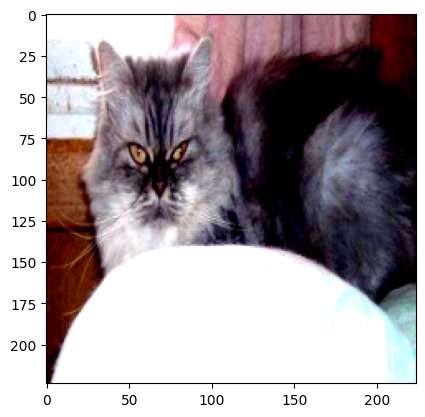

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

#show the image
imshow(images[0])


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512) 
        self.fc2 = nn.Linear(512, 2)  # 2 outputs: cat and dog

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# initial the ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

for epoch in range(20):  # loop over the dataset multiple times
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # use the val-set to compute the loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            val_loss += batch_loss.item()
    
    val_loss /= len(valid_loader)
    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Validation Loss: {val_loss}')
    
    # update the modle learn rate
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}, Current learning rate: {scheduler.optimizer.param_groups[0]['lr']}")


cuda
Epoch 1, Train Loss: 0.6457949876785278, Validation Loss: 0.6685249228326101
Epoch 1, Current learning rate: 0.001
Epoch 2, Train Loss: 0.5757690072059631, Validation Loss: 0.6464359514297001
Epoch 2, Current learning rate: 0.001
Epoch 3, Train Loss: 0.5745854377746582, Validation Loss: 0.6587650700220986
Epoch 3, Current learning rate: 0.001
Epoch 4, Train Loss: 0.5995498895645142, Validation Loss: 0.7301808940985847
Epoch 4, Current learning rate: 0.001
Epoch 5, Train Loss: 0.5113637447357178, Validation Loss: 0.8045250626783522
Epoch 5, Current learning rate: 0.001
Epoch 6, Train Loss: 0.15846896171569824, Validation Loss: 1.037131146779136
Epoch 6, Current learning rate: 0.0001
Epoch 7, Train Loss: 0.1087079793214798, Validation Loss: 1.2196389824625045
Epoch 7, Current learning rate: 0.0001
Epoch 8, Train Loss: 0.08329306542873383, Validation Loss: 1.3245836732879517
Epoch 8, Current learning rate: 0.0001
Epoch 9, Train Loss: 0.015095037408173084, Validation Loss: 1.399811722

In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {test_accuracy}%')




Accuracy of the network on the test images: 64.95304003954523%


In this project, our goal was to construct a Convolutional Neural Network (CNN) to differentiate between images of cats and dogs. The chosen CNN architecture comprises two convolutional layers and two max pooling layers, followed by two fully connected layers. The design of this structure is based on several key considerations: first, the convolutional layers are capable of effectively extracting valuable features from images, ranging from basic edges and color characteristics to more complex patterns and textures; second, the max pooling layers help in reducing the dimensionality of the features, decreasing computational demands while also aiding in mitigating the issue of overfitting; finally, given that this is a fundamental binary classification problem, such a relatively simple model is deemed sufficient.

During the compilation and training phases of the model, we utilized the cross-entropy loss function and the Adam optimizer, the latter of which is widely adopted for its ability to automatically adjust learning rates. After undergoing training over 20 epochs, the model's performance was evaluated based on its accuracy on a validation set, ultimately achieving an accuracy of 64.95%. Although this result indicates room for improvement for such a simple binary classification task, it provides us with a benchmark, pointing towards potential directions for future enhancements, such as adjusting the model structure, increasing the amount of data, or employing data augmentation techniques.


**Part2,**
The following models are widely used for transfer learning because of
their performance and architectural innovations:
1. VGG (e.g., VGG16 or VGG19).
2. GoogLeNet (e.g., InceptionV3).
3. Residual Network (e.g., ResNet50).
4. MobileNet (e.g., MobileNetV2)


Choose any one of the above models to perform the classification task you did in Part 1.
Evaluate the results using the same metrics as in Part 1. Are there any differences? Why
or why not? Describe in detail

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torchvision.models.resnet import ResNet50_Weights
from torch.utils.data import DataLoader

# load the model from the torchvision
weights = ResNet50_Weights.IMAGENET1K_V1  # use the pre-trained weights
model = models.resnet50(weights=weights)

# frezing the model parameters
for param in model.parameters():
    param.requires_grad = False

# 
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 ouputs: cat and dog

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



In [12]:
data_dir = {
    'train': 'C:\\Users\\LiWeiJun\\Desktop\\project in MI and AI\\hw5\\training_set\\training_set',
    'val': 'C:\\Users\\LiWeiJun\\Desktop\\project in MI and AI\\hw5\\test_set\\test_set',
    'test': 'C:\\Users\\LiWeiJun\\Desktop\\project in MI and AI\\hw5\\valid_set\\valid_set'
}

# Define the data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(data_dir[x], data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'val']}
dataloaders['test'] = DataLoader(image_datasets['test'], batch_size=64, shuffle=False)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)


for epoch in range(20): 
    model.train()
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # use the validation set to evaluate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(dataloaders['val'])
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')
    
    # update the learning rate
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}, Current learning rate: {scheduler.optimizer.param_groups[0]['lr']}")


Epoch 1, Validation Loss: 0.05231010237184819
Epoch 1, Current learning rate: 0.001
Epoch 2, Validation Loss: 0.04168137814849615
Epoch 2, Current learning rate: 0.001
Epoch 3, Validation Loss: 0.03968393433751771
Epoch 3, Current learning rate: 0.001
Epoch 4, Validation Loss: 0.04217281642195303
Epoch 4, Current learning rate: 0.001
Epoch 5, Validation Loss: 0.04529937311599497
Epoch 5, Current learning rate: 0.001
Epoch 6, Validation Loss: 0.04045308155400562
Epoch 6, Current learning rate: 0.001
Epoch 7, Validation Loss: 0.07572730121319182
Epoch 7, Current learning rate: 0.0001
Epoch 8, Validation Loss: 0.03984479224891402
Epoch 8, Current learning rate: 0.0001
Epoch 9, Validation Loss: 0.0399685650045285
Epoch 9, Current learning rate: 0.0001
Epoch 10, Validation Loss: 0.04066315948148258
Epoch 10, Current learning rate: 0.0001
Epoch 11, Validation Loss: 0.039738222454616334
Epoch 11, Current learning rate: 1e-05
Epoch 12, Validation Loss: 0.04063114016025793
Epoch 12, Current lea

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Accuracy of the network on the test images: 98.77591806145391%


Answer:Based on the results provided, we conducted a comparative analysis between the experimental outcomes of Part 1 and the previously discussed application of the ResNet50 model in a transfer learning task. It's evident that there are significant differences in training dynamics and final outcomes, especially regarding validation loss and test accuracy. To understand these differences more deeply, we focused on several key parameters and training dynamics.

In Part 1, the training loss decreased from 0.6457 to 0.0066, while the validation loss increased from 0.6685 to 1.4792. This indicates that the model learned many features from the training data but failed to generalize these features effectively to the validation data, leading to an increase in validation loss. This is a classic sign of overfitting. In contrast, the ResNet50 model demonstrated a more stable decrease in validation loss during training and achieved a final test accuracy of 98.77%, indicating superior generalization capabilities.

The learning rate adjustment strategy in Part 1 involved several changes, decreasing from 0.001 to 1e-07. These adjustments were based on validation loss, intending to improve the model's performance on the validation set by reducing the learning rate. However, despite the decreased learning rate, the validation loss continued to increase, suggesting that adjusting the learning rate alone might not be sufficient to address overfitting.

Comparatively, the experiment using the ResNet50 model also applied a learning rate adjustment strategy but showed better stability and generalization ability during training. This could be attributed to the design of the ResNet architecture, especially the residual connections, which help improve training in deep networks.

The experimental results from Part 1 showed a test accuracy of 64.95%, which is lower compared to the ResNet50 model. This further indicates generalization issues, where the model's performance on unseen data did not meet expectations. The lower test accuracy could be related to the model architecture, overfitting, or the approach to data handling (e.g., data augmentation, regularization).


**Part 3** (25 points): Use data augmentation to increase the diversity of your dataset by
applying random transformations such as image rotation (you can use any other
technique as well). Repeat the process from part 1 with this augmented data. Did you
observe any difference in results?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


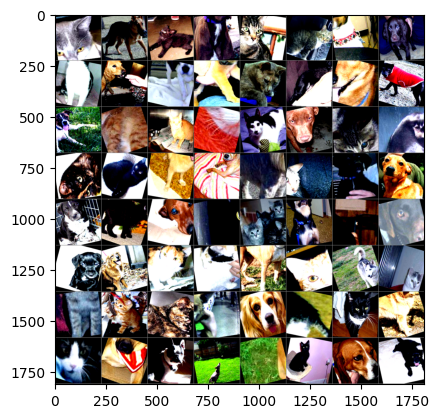

In [15]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# show the image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Define the data transforms with random data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # radomly crop the image to 224x224
    transforms.RandomHorizontalFlip(),  # randomly flip the image horizontally
    transforms.RandomRotation(20),  # randomly rotate the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # change the brightness, contrast, and saturation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize the image
])

# test and validation set transforms
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# show the image
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512) 
        self.fc2 = nn.Linear(512, 2)  # 2 outputs: cat and dog

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# initialize the ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

for epoch in range(20):  # 进行10个epochs的训练
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # use the validation set to evaluate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            val_loss += batch_loss.item()
    
    val_loss /= len(valid_loader)
    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Validation Loss: {val_loss}')
    
    # update the model learning rate
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}, Current learning rate: {scheduler.optimizer.param_groups[0]['lr']}")
    
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {test_accuracy}%')





cuda
Epoch 1, Train Loss: 0.6941217184066772, Validation Loss: 0.6932219550723121
Epoch 1, Current learning rate: 0.001
Epoch 2, Train Loss: 0.6939520835876465, Validation Loss: 0.6931744880146451
Epoch 2, Current learning rate: 0.001
Epoch 3, Train Loss: 0.6925689578056335, Validation Loss: 0.6930741156850543
Epoch 3, Current learning rate: 0.001
Epoch 4, Train Loss: 0.6923943161964417, Validation Loss: 0.6866375718797956
Epoch 4, Current learning rate: 0.001
Epoch 5, Train Loss: 0.6602243781089783, Validation Loss: 0.6635807535004994
Epoch 5, Current learning rate: 0.001
Epoch 6, Train Loss: 0.655864417552948, Validation Loss: 0.6634734358106341
Epoch 6, Current learning rate: 0.001
Epoch 7, Train Loss: 0.6980249881744385, Validation Loss: 0.6475019559027657
Epoch 7, Current learning rate: 0.001
Epoch 8, Train Loss: 0.6640720963478088, Validation Loss: 0.6477805972099304
Epoch 8, Current learning rate: 0.001
Epoch 9, Train Loss: 0.6704649925231934, Validation Loss: 0.6397083373296828

Same procedure for the part2 using the resnet50 model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim


weights = ResNet50_Weights.IMAGENET1K_V1  #get the weights
model = models.resnet50(weights=weights)

# freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# change the output layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 outputs: cat and dog

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)


for epoch in range(20): 
    model.train()
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # use the validation set to evaluate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(dataloaders['val'])
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')
    
    # update the learning rate
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}, Current learning rate: {scheduler.optimizer.param_groups[0]['lr']}")
    
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')


Epoch 1, Validation Loss: 0.07284628273919225
Epoch 1, Current learning rate: 0.001
Epoch 2, Validation Loss: 0.06457126239547506
Epoch 2, Current learning rate: 0.001
Epoch 3, Validation Loss: 0.1083651795051992
Epoch 3, Current learning rate: 0.001
Epoch 4, Validation Loss: 0.04569110873853788
Epoch 4, Current learning rate: 0.001
Epoch 5, Validation Loss: 0.04632178784231655
Epoch 5, Current learning rate: 0.001
Epoch 6, Validation Loss: 0.043345071404473856
Epoch 6, Current learning rate: 0.001
Epoch 7, Validation Loss: 0.06077666615601629
Epoch 7, Current learning rate: 0.001
Epoch 8, Validation Loss: 0.042404108186019585
Epoch 8, Current learning rate: 0.001
Epoch 9, Validation Loss: 0.041710507808602415
Epoch 9, Current learning rate: 0.001
Epoch 10, Validation Loss: 0.04265964339720085
Epoch 10, Current learning rate: 0.001
Epoch 11, Validation Loss: 0.042053941142512485
Epoch 11, Current learning rate: 0.001
Epoch 12, Validation Loss: 0.04667560307279928
Epoch 12, Current lear

Answer:Through the comparison of experimental results before and after the application of data augmentation—specifically, without using data augmentation (original Part 1 and Part 2) and with the use of data augmentation—it's clear to see the significant impact data augmentation has on model performance. Before data augmentation, the test result for Part 1 was 64.953%, which increased to 69.896% after data augmentation, indicating that introducing more sample diversity through data augmentation helped the model learn more generalizable features, thereby improving performance on unseen data. Though the improvement was modest, it is still valuable considering it was achieved under the same network architecture and training strategy. For Part 2, the performance remained stable with a minimal increase from 98.775% to 98.800% after data augmentation, suggesting that additional data diversity has limited impact on models that already achieve high accuracy. However, maintaining high accuracy while increasing data diversity also means that the model's generalizability is ensured. Overall, data augmentation significantly improved the test accuracy of models with originally lower performance and helped models with high accuracy maintain their performance level, emphasizing the importance of data augmentation in enhancing model generalizability and preventing overfitting. By applying random transformations to images, such as random cropping, horizontal flipping, rotation, and color jittering, the models are forced to learn more universal features, rather than relying on specific sample distributions in the training set, thereby boosting their generalizability to new data.

**Task 2 (30 points):**
 Part 1 (15 points): Variational Autoencoder (VAE): Here is a complete implementation
of a VAE in TensorFlow: https://www.tensorflow.org/tutorials/generative/cvae
PyTorch implementation is fine too.
Following these steps try generating images using the same encoder-decoder architecture using
a different Image dataset (other than MNIST).

Files already downloaded and verified
Files already downloaded and verified
Train time: 1 [0/50000] Loss: 2136.477051
Train time: 1 [6400/50000] Loss: 2004.814575
Train time: 1 [12800/50000] Loss: 1955.771729
Train time: 1 [19200/50000] Loss: 1943.983521
Train time: 1 [25600/50000] Loss: 1919.739502
Train time: 1 [32000/50000] Loss: 1924.878296
Train time: 1 [38400/50000] Loss: 1927.218506
Train time: 1 [44800/50000] Loss: 1928.632568
====> Epoch: 1 Average loss: 1956.0237
====> test set average loss: 1906.7635
Train time: 2 [0/50000] Loss: 1921.806519
Train time: 2 [6400/50000] Loss: 1889.204834
Train time: 2 [12800/50000] Loss: 1955.461670
Train time: 2 [19200/50000] Loss: 1858.912231
Train time: 2 [25600/50000] Loss: 1860.031982
Train time: 2 [32000/50000] Loss: 1861.917114
Train time: 2 [38400/50000] Loss: 1835.332031
Train time: 2 [44800/50000] Loss: 1883.112061
====> Epoch: 2 Average loss: 1887.9853
====> test set average loss: 1880.9404
Train time: 3 [0/50000] Loss: 1877.958374


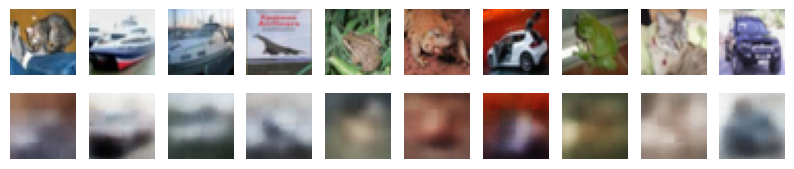

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # encode
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # 3 input channels, 16 output channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # pool layer 1
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # pool layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # pool layer 3
        )

        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(256, 64)

        # decode
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Sigmoid(), # 0-1
        )

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc2(self.fc1(x))
        log_var = self.fc3(self.fc1(x))
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    
    
    
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train time: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print(f'====> test set average loss: {test_loss:.4f}')
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    
    
def visualize(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)
        recon = recon.cpu()
        data = data.cpu()
        fig, axs = plt.subplots(2, 10, figsize=(10, 2))
        for i in range(10):
            axs[0, i].imshow(np.transpose(data[i], (1, 2, 0)))
            axs[0, i].axis('off')
            axs[1, i].imshow(np.transpose(recon[i], (1, 2, 0)))
            axs[1, i].axis('off')
        plt.show()

visualize(model, device, test_loader)



In [5]:
from torchsummary import summary

print(summary(model, (3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 256]         262,400
           Linear-11                   [-1, 64]          16,448
           Linear-12                  [-1, 256]         262,400
           Linear-13                   [-1, 64]          16,448
           Linear-14                  [

**Part 2 (15 points):** Generative Adversarial Networks (GANs): Repeat part 1 (use same
dataset) and implement a GAN model to generate high quality synthetic images. You may
follow steps outlined here: https://www.tensorflow.org/tutorials/generative/dcgan


cuda
Files already downloaded and verified
[0/10][0/391]	Loss_D: 1.7207	Loss_G: 5.9179	D(x): 0.4757	D(G(z)): 0.5107 / 0.0043
[0/10][50/391]	Loss_D: 0.0211	Loss_G: 35.0041	D(x): 0.9799	D(G(z)): 0.0000 / 0.0000
[0/10][100/391]	Loss_D: 0.0016	Loss_G: 35.8305	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
[0/10][150/391]	Loss_D: 0.0008	Loss_G: 32.6057	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[0/10][200/391]	Loss_D: 0.5074	Loss_G: 8.8320	D(x): 0.7406	D(G(z)): 0.0066 / 0.0073
[0/10][250/391]	Loss_D: 0.5831	Loss_G: 2.7144	D(x): 0.7190	D(G(z)): 0.1427 / 0.0792
[0/10][300/391]	Loss_D: 0.1602	Loss_G: 5.9518	D(x): 0.9075	D(G(z)): 0.0511 / 0.0031
[0/10][350/391]	Loss_D: 0.1976	Loss_G: 12.1472	D(x): 0.8588	D(G(z)): 0.0001 / 0.0000


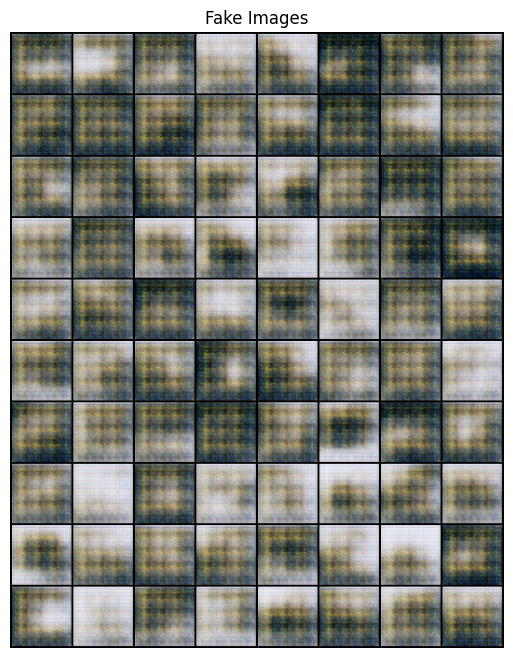

[1/10][0/391]	Loss_D: 0.2267	Loss_G: 7.6909	D(x): 0.8475	D(G(z)): 0.0010 / 0.0038
[1/10][50/391]	Loss_D: 0.2833	Loss_G: 5.9968	D(x): 0.9170	D(G(z)): 0.1215 / 0.0052
[1/10][100/391]	Loss_D: 0.2947	Loss_G: 4.4659	D(x): 0.8193	D(G(z)): 0.0649 / 0.0157
[1/10][150/391]	Loss_D: 0.6141	Loss_G: 1.9486	D(x): 0.7207	D(G(z)): 0.1569 / 0.1949
[1/10][200/391]	Loss_D: 0.8816	Loss_G: 6.3987	D(x): 0.8895	D(G(z)): 0.4675 / 0.0031
[1/10][250/391]	Loss_D: 0.5702	Loss_G: 4.8674	D(x): 0.8674	D(G(z)): 0.3180 / 0.0109
[1/10][300/391]	Loss_D: 0.7462	Loss_G: 2.2984	D(x): 0.6661	D(G(z)): 0.1568 / 0.1513
[1/10][350/391]	Loss_D: 0.2441	Loss_G: 3.6568	D(x): 0.9012	D(G(z)): 0.1187 / 0.0344


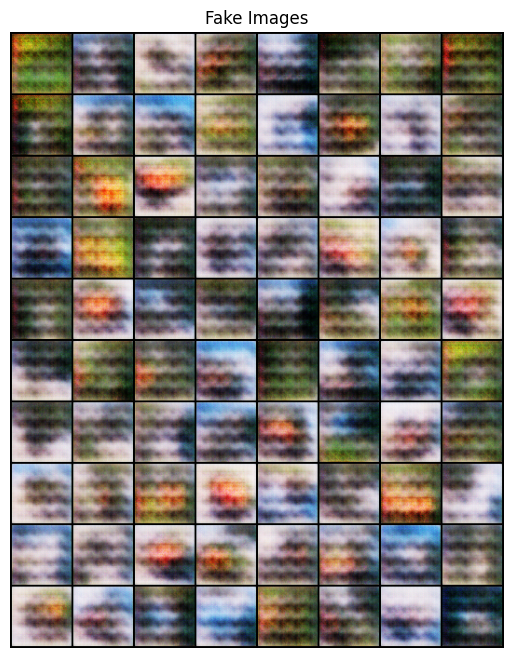

[2/10][0/391]	Loss_D: 0.3560	Loss_G: 3.1336	D(x): 0.8535	D(G(z)): 0.1508 / 0.0576
[2/10][50/391]	Loss_D: 0.4488	Loss_G: 4.6965	D(x): 0.8729	D(G(z)): 0.2306 / 0.0142
[2/10][100/391]	Loss_D: 0.4256	Loss_G: 3.2676	D(x): 0.8384	D(G(z)): 0.1875 / 0.0528
[2/10][150/391]	Loss_D: 0.3279	Loss_G: 3.7296	D(x): 0.9156	D(G(z)): 0.1919 / 0.0319
[2/10][200/391]	Loss_D: 1.2502	Loss_G: 6.2427	D(x): 0.9590	D(G(z)): 0.5971 / 0.0045
[2/10][250/391]	Loss_D: 0.5628	Loss_G: 5.3318	D(x): 0.9457	D(G(z)): 0.3403 / 0.0084
[2/10][300/391]	Loss_D: 0.4991	Loss_G: 2.6637	D(x): 0.7667	D(G(z)): 0.1744 / 0.0891
[2/10][350/391]	Loss_D: 0.6745	Loss_G: 3.9701	D(x): 0.8331	D(G(z)): 0.3348 / 0.0281


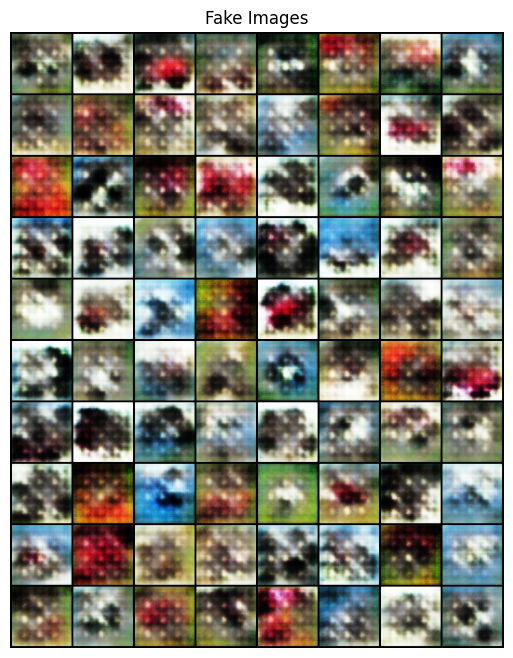

[3/10][0/391]	Loss_D: 0.6298	Loss_G: 3.6692	D(x): 0.8367	D(G(z)): 0.2950 / 0.0427
[3/10][50/391]	Loss_D: 0.4234	Loss_G: 2.4465	D(x): 0.7497	D(G(z)): 0.0770 / 0.1303
[3/10][100/391]	Loss_D: 0.7531	Loss_G: 2.1781	D(x): 0.6573	D(G(z)): 0.2011 / 0.1591
[3/10][150/391]	Loss_D: 1.2433	Loss_G: 0.7771	D(x): 0.3782	D(G(z)): 0.0402 / 0.5265
[3/10][200/391]	Loss_D: 0.4698	Loss_G: 3.5760	D(x): 0.8837	D(G(z)): 0.2500 / 0.0416
[3/10][250/391]	Loss_D: 0.5777	Loss_G: 4.6903	D(x): 0.8909	D(G(z)): 0.3135 / 0.0199
[3/10][300/391]	Loss_D: 0.6174	Loss_G: 4.3049	D(x): 0.8535	D(G(z)): 0.2899 / 0.0249
[3/10][350/391]	Loss_D: 0.6559	Loss_G: 4.2281	D(x): 0.7884	D(G(z)): 0.2753 / 0.0225


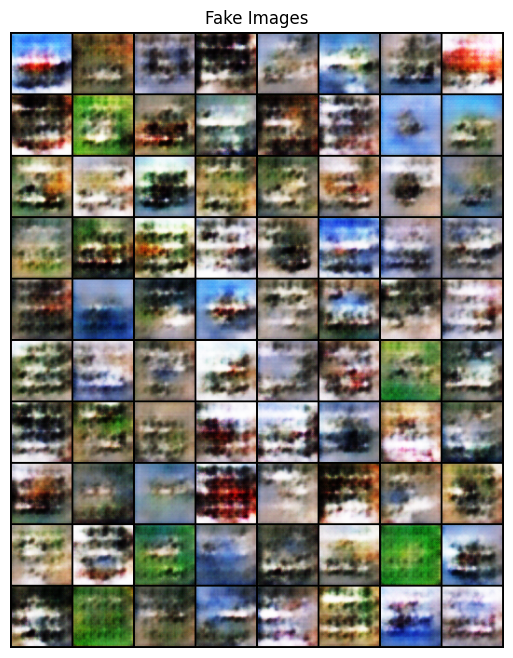

[4/10][0/391]	Loss_D: 0.5923	Loss_G: 2.8661	D(x): 0.7162	D(G(z)): 0.1602 / 0.1005
[4/10][50/391]	Loss_D: 1.2303	Loss_G: 1.9808	D(x): 0.4228	D(G(z)): 0.1666 / 0.2052
[4/10][100/391]	Loss_D: 0.6014	Loss_G: 3.4783	D(x): 0.7295	D(G(z)): 0.1775 / 0.0489
[4/10][150/391]	Loss_D: 0.4793	Loss_G: 3.5007	D(x): 0.8192	D(G(z)): 0.2036 / 0.0470
[4/10][200/391]	Loss_D: 0.5678	Loss_G: 4.3414	D(x): 0.8617	D(G(z)): 0.3034 / 0.0207
[4/10][250/391]	Loss_D: 0.5061	Loss_G: 4.4358	D(x): 0.8887	D(G(z)): 0.2850 / 0.0171
[4/10][300/391]	Loss_D: 0.4921	Loss_G: 3.1325	D(x): 0.8946	D(G(z)): 0.2875 / 0.0594
[4/10][350/391]	Loss_D: 0.8970	Loss_G: 3.5174	D(x): 0.8870	D(G(z)): 0.4920 / 0.0435


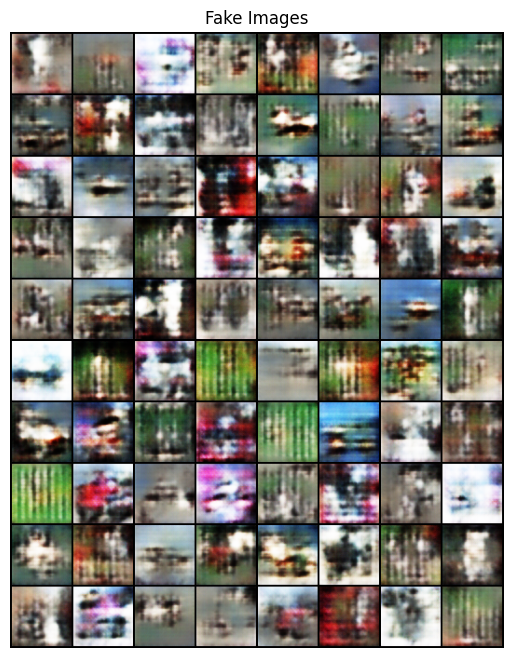

[5/10][0/391]	Loss_D: 0.4162	Loss_G: 4.3968	D(x): 0.9249	D(G(z)): 0.2626 / 0.0178
[5/10][50/391]	Loss_D: 0.8298	Loss_G: 1.7227	D(x): 0.5796	D(G(z)): 0.1642 / 0.2263
[5/10][100/391]	Loss_D: 0.7579	Loss_G: 3.3364	D(x): 0.8716	D(G(z)): 0.4145 / 0.0491
[5/10][150/391]	Loss_D: 0.6388	Loss_G: 2.6392	D(x): 0.7283	D(G(z)): 0.2327 / 0.0949
[5/10][200/391]	Loss_D: 0.6366	Loss_G: 3.5195	D(x): 0.8675	D(G(z)): 0.3596 / 0.0408
[5/10][250/391]	Loss_D: 0.7473	Loss_G: 2.4075	D(x): 0.6543	D(G(z)): 0.2005 / 0.1217
[5/10][300/391]	Loss_D: 0.6118	Loss_G: 1.9745	D(x): 0.6667	D(G(z)): 0.1165 / 0.1694
[5/10][350/391]	Loss_D: 1.0733	Loss_G: 4.9303	D(x): 0.8817	D(G(z)): 0.5490 / 0.0109


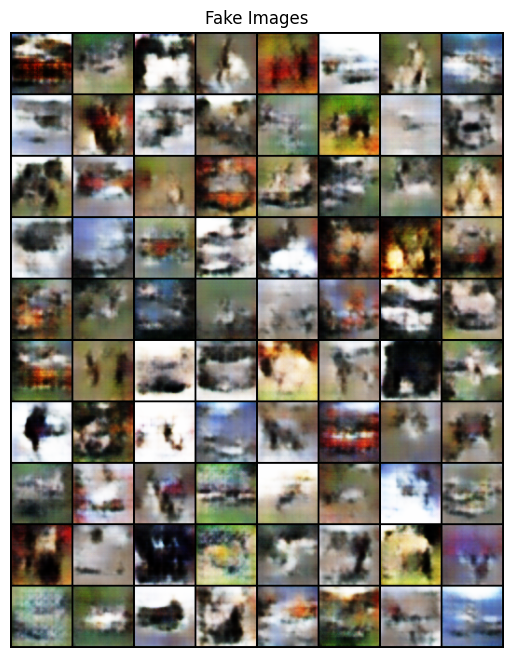

[6/10][0/391]	Loss_D: 0.6332	Loss_G: 3.1772	D(x): 0.9126	D(G(z)): 0.3828 / 0.0591
[6/10][50/391]	Loss_D: 1.0889	Loss_G: 1.8611	D(x): 0.7753	D(G(z)): 0.4765 / 0.2203
[6/10][100/391]	Loss_D: 0.4971	Loss_G: 2.3532	D(x): 0.7764	D(G(z)): 0.1871 / 0.1182
[6/10][150/391]	Loss_D: 0.9799	Loss_G: 1.3514	D(x): 0.4797	D(G(z)): 0.0950 / 0.2969
[6/10][200/391]	Loss_D: 0.7680	Loss_G: 1.8949	D(x): 0.5890	D(G(z)): 0.1360 / 0.1942
[6/10][250/391]	Loss_D: 1.2382	Loss_G: 1.1241	D(x): 0.4136	D(G(z)): 0.1633 / 0.3908
[6/10][300/391]	Loss_D: 1.1940	Loss_G: 1.1303	D(x): 0.3945	D(G(z)): 0.1070 / 0.3732
[6/10][350/391]	Loss_D: 0.6148	Loss_G: 2.1070	D(x): 0.7531	D(G(z)): 0.2413 / 0.1510


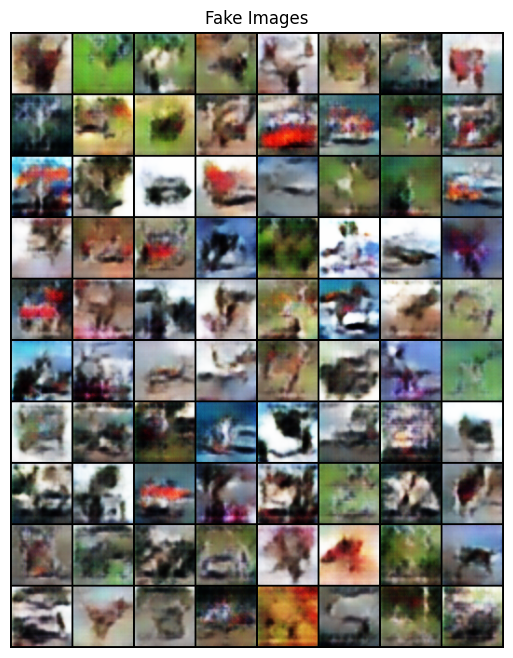

[7/10][0/391]	Loss_D: 0.6349	Loss_G: 2.2119	D(x): 0.6494	D(G(z)): 0.1309 / 0.1432
[7/10][50/391]	Loss_D: 0.8013	Loss_G: 3.7616	D(x): 0.8986	D(G(z)): 0.4598 / 0.0322
[7/10][100/391]	Loss_D: 1.6562	Loss_G: 1.4483	D(x): 0.2463	D(G(z)): 0.0277 / 0.2844
[7/10][150/391]	Loss_D: 1.2178	Loss_G: 0.9015	D(x): 0.3689	D(G(z)): 0.0808 / 0.4472
[7/10][200/391]	Loss_D: 1.0708	Loss_G: 5.9921	D(x): 0.9645	D(G(z)): 0.5928 / 0.0041
[7/10][250/391]	Loss_D: 0.6600	Loss_G: 1.9580	D(x): 0.6476	D(G(z)): 0.1442 / 0.1763
[7/10][300/391]	Loss_D: 0.3998	Loss_G: 2.6329	D(x): 0.8428	D(G(z)): 0.1882 / 0.0878
[7/10][350/391]	Loss_D: 1.0527	Loss_G: 3.0201	D(x): 0.9040	D(G(z)): 0.5399 / 0.0753


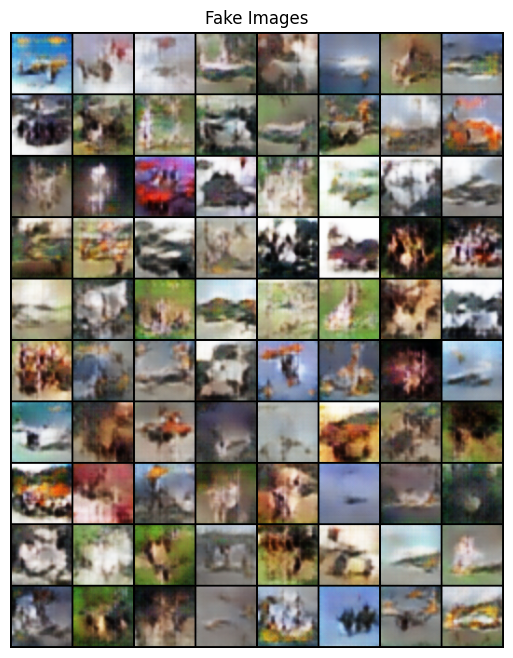

[8/10][0/391]	Loss_D: 0.7539	Loss_G: 3.8599	D(x): 0.9126	D(G(z)): 0.4371 / 0.0303
[8/10][50/391]	Loss_D: 0.5231	Loss_G: 2.7363	D(x): 0.8212	D(G(z)): 0.2493 / 0.0896
[8/10][100/391]	Loss_D: 1.2546	Loss_G: 5.4131	D(x): 0.9570	D(G(z)): 0.6614 / 0.0067
[8/10][150/391]	Loss_D: 0.7056	Loss_G: 3.3910	D(x): 0.8550	D(G(z)): 0.3852 / 0.0422
[8/10][200/391]	Loss_D: 0.3193	Loss_G: 2.5408	D(x): 0.8057	D(G(z)): 0.0857 / 0.0973
[8/10][250/391]	Loss_D: 2.5312	Loss_G: 5.8442	D(x): 0.9975	D(G(z)): 0.8878 / 0.0046
[8/10][300/391]	Loss_D: 0.9974	Loss_G: 5.8459	D(x): 0.9907	D(G(z)): 0.5830 / 0.0041
[8/10][350/391]	Loss_D: 0.8348	Loss_G: 3.0924	D(x): 0.7644	D(G(z)): 0.3802 / 0.0590


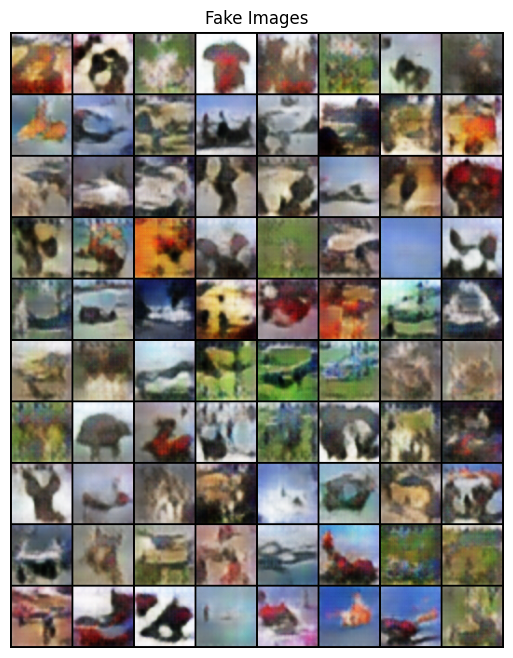

[9/10][0/391]	Loss_D: 0.5065	Loss_G: 2.4343	D(x): 0.6643	D(G(z)): 0.0489 / 0.1171
[9/10][50/391]	Loss_D: 0.0768	Loss_G: 4.9523	D(x): 0.9419	D(G(z)): 0.0154 / 0.0097
[9/10][100/391]	Loss_D: 0.7514	Loss_G: 4.8901	D(x): 0.8666	D(G(z)): 0.4228 / 0.0103
[9/10][150/391]	Loss_D: 0.4871	Loss_G: 1.6800	D(x): 0.6712	D(G(z)): 0.0487 / 0.2319
[9/10][200/391]	Loss_D: 0.8793	Loss_G: 0.5324	D(x): 0.4906	D(G(z)): 0.0733 / 0.6246
[9/10][250/391]	Loss_D: 1.4553	Loss_G: 0.7683	D(x): 0.3621	D(G(z)): 0.2225 / 0.5058
[9/10][300/391]	Loss_D: 1.5857	Loss_G: 0.6814	D(x): 0.2462	D(G(z)): 0.0205 / 0.5440
[9/10][350/391]	Loss_D: 0.2292	Loss_G: 2.9255	D(x): 0.8684	D(G(z)): 0.0769 / 0.0662


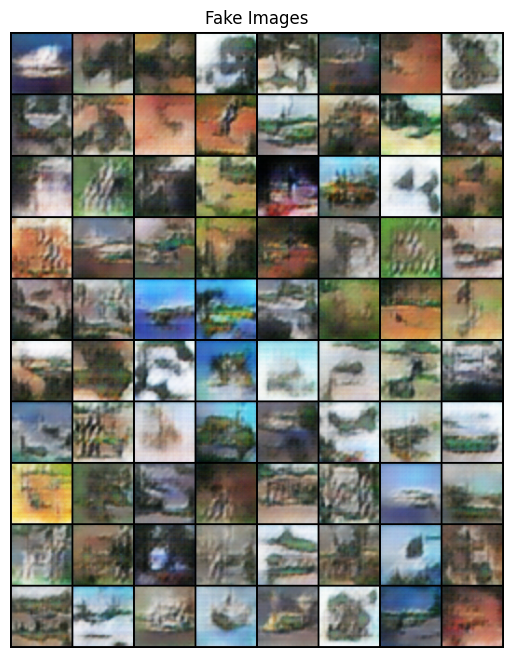

---------------------------------


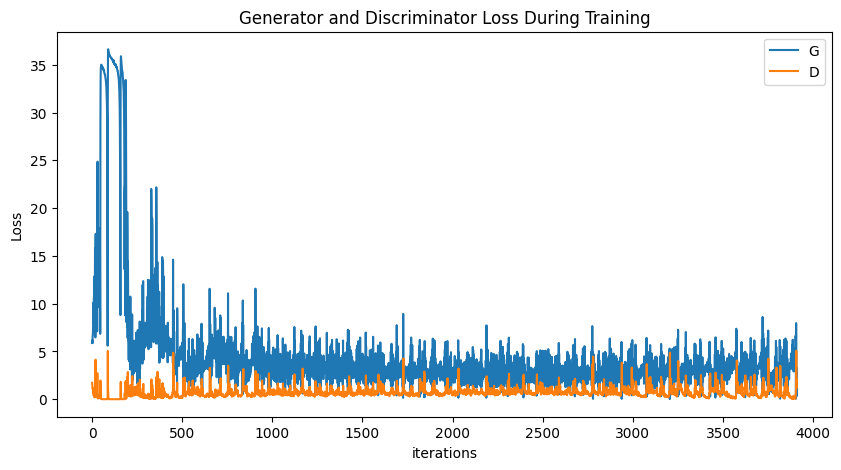

In [6]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# define the generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

#defining the discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


nz = 100
ngf = 64 
ndf = 64 
nc = 3
# initialize the model
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

# initialize the weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# set the loss function and optimizer
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# load the data set
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
real_label = 1.
fake_label = 0.
num_epochs=10
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # update the gen: max log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # update the  discri: max log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # plot the training loss
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    
 
    with torch.no_grad():
        fake = netG(noise).detach().cpu()
    img_list = utils.make_grid(fake, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list, (1,2,0)))
    plt.show()

print("---------------------------------")
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()